# Homework 03

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images. It did ... OK. There is significant overfitting of this model. There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture. Change one or more of the following:

* The number of convolutions between downsampling
* The number of filters in each layer
* The initial "patchify" layer
* Another hyper-parameter of your choosing

And compare your final validation accuracy to the accuracy shown here. Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train. You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

# Define the transformations for the training data
training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.85, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Define the transformations for the test data (usually no data augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

# Load the CIFAR-10 training data
training_data = torchvision.datasets.CIFAR10(
    root="datasets/CIFAR-10/",
    train=True,
    download=True,
    transform=training_transform
)

# Load the CIFAR-10 test data
test_data = torchvision.datasets.CIFAR10(
    root="datasets/CIFAR-10/",
    train=False,
    download=True,
    transform=test_transform
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


In [2]:
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=4)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=4)

class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):

    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x
        
def evaluate(dataloader, model, loss_fn, val_bar, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move data to the correct device
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= size
    
    accuracy = 100 * correct
    return accuracy, loss


def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar, device):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move data to the correct device
        optimizer.zero_grad()  # Reset gradients
        pred = model(X)  # Forward pass
        loss = loss_fn(pred, y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        progress_bar.update()
        

## First, modify the number of convolutions between downsampling.
The number of convolutions will be 2, 3, and 4, respectively. 
The loss and accuracy are plotted against each epoch

In [3]:
#from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt

####  The number of convolutions 2:
model = Classifier(64, 4, 2)


## Initialize lists to hold the metrics
train_losses2 = []
train_accuracies2 = []
val_losses2 = []
val_accuracies2 = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar, device)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval, device)
        train_losses2.append(loss)
        train_accuracies2.append(acc)
        # print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar, device)
        val_losses2.append(loss_val)
        val_accuracies2.append(acc_val)
        # print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        
        

####  The number of convolutions 3:
model = Classifier(64, 4, 3)


## Initialize lists to hold the metrics
train_losses3 = []
train_accuracies3 = []
val_losses3 = []
val_accuracies3 = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar, device)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval, device)
        train_losses3.append(loss)
        train_accuracies3.append(acc)
        # print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar, device)
        val_losses3.append(loss_val)
        val_accuracies3.append(acc_val)
        # print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        

        
        
####  The number of convolutions 4:
model = Classifier(64, 4, 4)


## Initialize lists to hold the metrics
train_losses4 = []
train_accuracies4 = []
val_losses4 = []
val_accuracies4 = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)


for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar, device)
    
    # checking on the training loss and accuracy once per epoch
        
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
        acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval, device)
        train_losses4.append(loss)
        train_accuracies4.append(acc)
        # print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
        
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar, device)
        val_losses4.append(loss_val)
        val_accuracies4.append(acc_val)
        # print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
        


Using cuda device


Validate Epoch 29: 100%|██████████| 79/79 [00:01<00:00, 40.51it/s]


Using cuda device


Validate Epoch 29: 100%|██████████| 79/79 [00:02<00:00, 33.61it/s]


Using cuda device


Validate Epoch 29: 100%|██████████| 79/79 [00:02<00:00, 26.50it/s]


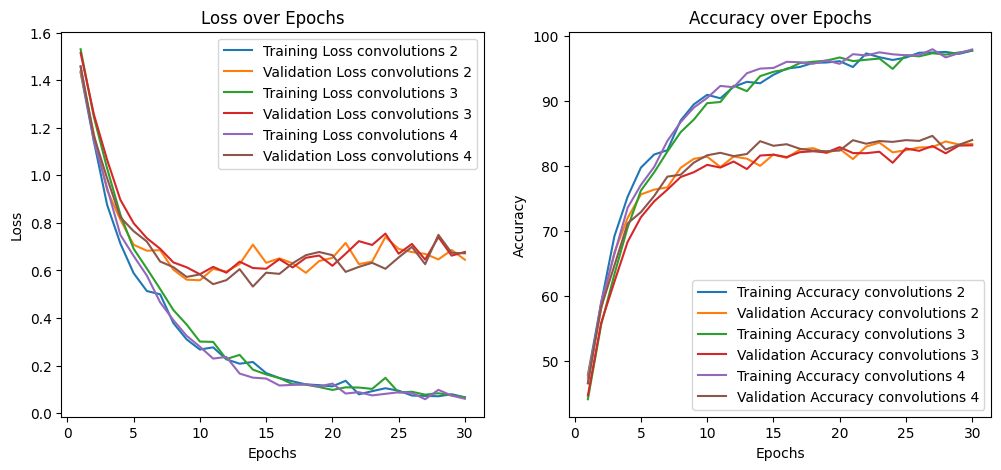

In [7]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses2, label='Training Loss convolutions 2')
plt.plot(range(1, epochs+1), val_losses2, label='Validation Loss convolutions 2')
plt.plot(range(1, epochs+1), train_losses3, label='Training Loss convolutions 3')
plt.plot(range(1, epochs+1), val_losses3, label='Validation Loss convolutions 3')
plt.plot(range(1, epochs+1), train_losses4, label='Training Loss convolutions 4')
plt.plot(range(1, epochs+1), val_losses4, label='Validation Loss convolutions 4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies2, label='Training Accuracy convolutions 2')
plt.plot(range(1, epochs+1), val_accuracies2, label='Validation Accuracy convolutions 2')
plt.plot(range(1, epochs+1), train_accuracies3, label='Training Accuracy convolutions 3')
plt.plot(range(1, epochs+1), val_accuracies3, label='Validation Accuracy convolutions 3')
plt.plot(range(1, epochs+1), train_accuracies4, label='Training Accuracy convolutions 4')
plt.plot(range(1, epochs+1), val_accuracies4, label='Validation Accuracy convolutions 4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

# Discussion

From the two plots provided above, it is evident that predictions on the training data are more accurate for both loss and accuracy metrics. However, increasing the number of convolutions between downsampling does not yield improvement in predictions after 30 epochs of training.

Possible guesses:

Increasing the number of convolutions can lead to a more complex model. If the model becomes too complex, it might start to overfit the training data, learning the noise in the data as if it were significant. This would mean it performs well on the training data but poorly on unseen data. 
